<a href="https://colab.research.google.com/github/mehdihosseinimoghadam/Signal-Processing/blob/main/vq_VAE_for_Melspectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) Voice Reconstruction Using Vq-VAE

This notebook proposes a method on how to reconstruct speech using vq-vae which has been first introduced by [ Oord et. al](https://arxiv.org/abs/1711.00937).



![picture](https://drive.google.com/uc?export=view&id=1XFC5_OYnwge7g14jmKZqHaBwuajsVDyP)



#2) Vq-VAE vs VAE
Main difference between Vq-VAE & VAE is that VAE learns a continuous latent representation of a given dataset, but Vq-VAE learns a discrete latent representation of dataset.  



#3) Architecture


![picture](https://drive.google.com/uc?export=view&id=1hVMCRd4ZeBMM581iLa5ZKV1C-gT4IUsQ)


- At the begining, encoder takes a batch of images with input shape of $X:(n, h, w, c)$ and outputs $Z_{e}:(n, h, w, d)$

- Then vector quantization layer takes $Z_{e}$ and for each vector in $Z_{e}$ it selects the nearest vector from the codebook based on $L_{2}$ norm and outputs $Z_{q}$ 

- Finally decoder takes $Z_{q}$ and reconstructs the input $X$.

#4) Detailed View on Vq-VAE Architecture




![picture](https://drive.google.com/uc?export=view&id=1a---6D9Nzvf7VJpfR_zDGujXSpJwG6cJ)





- Reshaping: First of all we need to reshape input from $(n, h, w, d)$ to $(n*h*w, d)$.

- Calculating Distances: For each of d-dimensional vectors, we calculate their distance from each k, d-dimensional vectors in codebook and get a matrix of $(n*h*w, k)$.

- Argmin: Next for each row of the matrix, we apply argmin function to get the nearest vector index from codebook and do one-hot encoding no each row (in fact the value of the nearest vector will be 1 and rest would be 0).

- Index from Codebook: After that we multiply the one-hotted matrix to the whole codebook and we get a matrix of $(n*h*w, d)$ dimension.

- Finally we reshape $(n*h*w, d)$ to $(n, h, w, d)$ and give it to the decoder to reconstruct the input data 



#5) Some High Resolution Constructed Images


![picture](https://drive.google.com/uc?export=view&id=1rAicXUoCWrLEKtA-Wyvwj2ydNhsbQzk3)


### References
[1] https://shashank7-iitd.medium.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a

[2] https://arxiv.org/pdf/1711.00937.pdf

## Some imports and MelSpectrogram function





In [ ]:
import torch
from torch import nn
## Some imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as idp
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.figure(figsize=(10,30))
  plt.show(block=False)

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 16000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d luantm/speech-commands-tensorflow

100% 4.51G/4.51G [00:48<00:00, 94.6MB/s]
100% 4.51G/4.51G [00:48<00:00, 99.3MB/s]


In [ ]:
%%capture
!unzip /content/speech-commands-tensorflow.zip

## DataLoader Structure

- Class: EnglishCommands
  - __init__
  - __len__
  - __getitem__
   - change_sample_rate
   - right_padding
   - mix_down
   - transformations
   - cut_signal


In [ ]:
import csv

with open('/content/speechdataset/SpeechDataset/testing_list.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split("/") for line in stripped if line)
    with open('log.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('command', 'path'))
        writer.writerows(lines)

In [ ]:
from matplotlib.cbook import get_label
from torch.utils.data import Dataset
import torchaudio
class EnglishCommands(Dataset):
  def __init__(self,
               annotation_file,
               audio_dir,
               target_sample_rate,
               transformation,
               num_sample):


    self.annotation_file = pd.read_csv(annotation_file).iloc[1:700,:]
    self.audio_dir = audio_dir
    self.target_sample_rate = target_sample_rate
    self.transformation = transformation
    self.num_sample = num_sample


  def __len__(self):
    return len(self.annotation_file)


  def __getitem__(self, index):
    path = self.get_path(index)
    label = self.get_label(index)
    signal, sr = torchaudio.load(path)
    signal = self.change_sample_rate(signal, sr)
    signal = self.right_padding(signal)
    signal = self.cut_signal(signal)
    signal = self.transformation(signal)
    return signal, label



  def get_path(self, index):
    path = str(self.audio_dir) + "/" + str(self.annotation_file.iloc[index,0]) + "/" + str(self.annotation_file.iloc[index,1])  
    return path


  def get_label(self, index):  
    return self.annotation_file.iloc[index,0]

  def change_sample_rate(self, signal, sr):
    if sr != self.target_sample_rate:  
       signal = torchaudio.transforms.Resample(sr, self.target_sample_rate)
       return signal  
    return signal   

  def right_padding(self, signal):
    if signal.shape[1] < self.num_sample:
      padd = self.num_sample - signal.shape[1] 
      last_dim_padding = (0, padd)
      signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal
    return signal  


  def cut_signal(self, signal): 
    if signal.shape[1] > self.num_sample:
       signal = signal[:, :self.num_sample]
       return signal
    return signal   


699
(tensor([[[2.2711e-01, 3.7324e-02, 3.3804e-02,  ..., 1.2152e+00,
          6.2450e-02, 3.5692e-01],
         [9.6858e-02, 1.7977e-02, 4.1976e-01,  ..., 2.3965e+00,
          1.6095e+00, 9.0400e-01],
         [9.7352e-02, 1.1866e-01, 7.7365e-01,  ..., 3.9120e+00,
          4.1662e+00, 2.0406e+00],
         ...,
         [7.4076e-04, 7.2965e-04, 2.5004e-03,  ..., 7.7937e-04,
          1.4489e-03, 1.2459e-03],
         [9.3401e-04, 5.8919e-04, 2.1035e-03,  ..., 1.8868e-03,
          1.1003e-03, 8.7202e-04],
         [9.0534e-04, 4.3136e-04, 9.4019e-04,  ..., 1.4105e-03,
          1.6796e-03, 2.3815e-03]]]), 'right')
torch.Size([1, 128, 32])


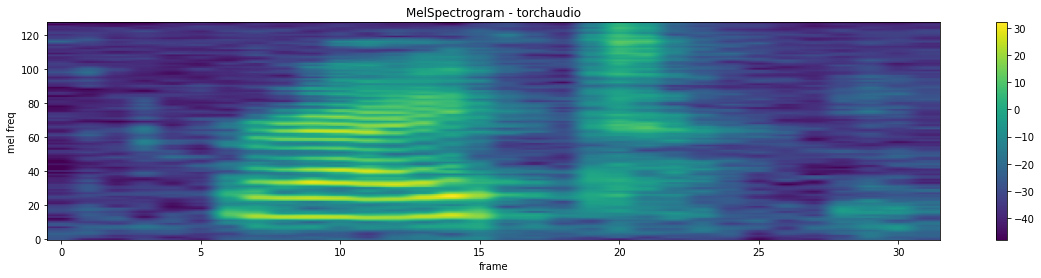

<Figure size 720x2160 with 0 Axes>

/content/speechdataset/SpeechDataset/right/692a88e6_nohash_3.wav


In [ ]:
SR = 16000
N_FFT=1024
HOP_LENGTH=512
N_MELS=128

melspec = torchaudio.transforms.MelSpectrogram(sample_rate = SR,
                                               n_fft = N_FFT,
                                               window_fn = torch.hann_window,
                                               hop_length = HOP_LENGTH,
                                               n_mels = N_MELS)

EC = EnglishCommands("/content/log.csv",
                "/content/speechdataset/SpeechDataset",
                16000,
                melspec,
                16000)

print(len(EC))
print(EC[6])
print(EC[6][0].shape)

plot_spectrogram(
    EC[100][0][0], title="MelSpectrogram - torchaudio", ylabel='mel freq')
print(EC.get_path(100))
ipd.Audio(EC.get_path(100))

## Full VAE Code

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
train_dataloader = DataLoader(EC, batch_size=16, shuffle=True)

## Train VAE

In [ ]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 16
img_size = (128, 32) # (width, height)

input_dim = 1
hidden_dim = 256
n_embeddings= 512
output_dim = 1

lr = 2e-4

epochs = 1005

print_step = 100

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.batch1 = nn.BatchNorm2d(hidden_dim)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        self.batch2 = nn.BatchNorm2d(hidden_dim)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.batch3 = nn.BatchNorm2d(hidden_dim)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        self.batch4 = nn.BatchNorm2d(output_dim)
        
    def forward(self, x):
        
        x = self.batch1(self.strided_conv_1(x))
        x = self.batch2(self.strided_conv_2(x))
        
        x = F.relu(x)
        y = self.batch3(self.residual_conv_1(x))
        y = y+x
        
        x = F.relu(y)
        y = self.batch4(self.residual_conv_2(x))
        y = y+x
        
        return y

In [ ]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.batch1 = nn.BatchNorm2d(hidden_dim)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        self.batch2 = nn.BatchNorm2d(hidden_dim)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.batch3 = nn.BatchNorm2d(hidden_dim)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        self.batch4 = nn.BatchNorm2d(output_dim)
        
    def forward(self, x):
        
        y = self.batch1(self.residual_conv_1(x))
        y = y+x
        x = F.relu(y)
        
        y = self.batch2(self.residual_conv_2(x))
        y = y+x
        y = F.relu(y)
        
        y = self.batch3(self.strided_t_conv_1(y))
        y = self.strided_t_conv_2(y)
        
        return y

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [ ]:
def save_checkpoint(state, filename="/content/drive/MyDrive/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


In [ ]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

In [ ]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 2631939


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

Start training VQ-VAE...
=> Loading checkpoint
0


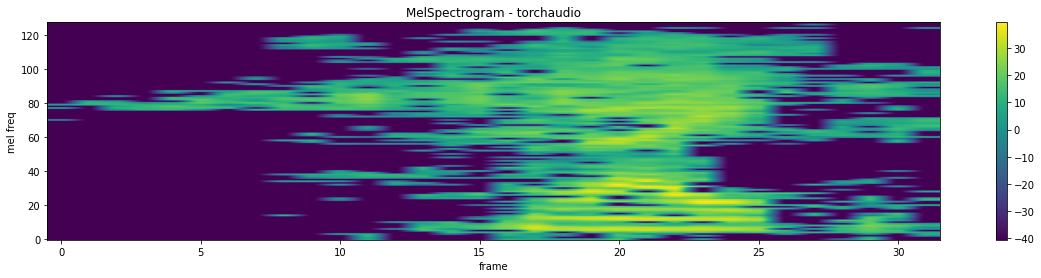

<Figure size 720x2160 with 0 Axes>

epoch: 1   step: 44   recon_loss: 503.9794921875   perplexity:  146.45562744140625 
		commit_loss:  14.70019817352295   codebook loss:  58.8007926940918   total_loss:  577.48046875
=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


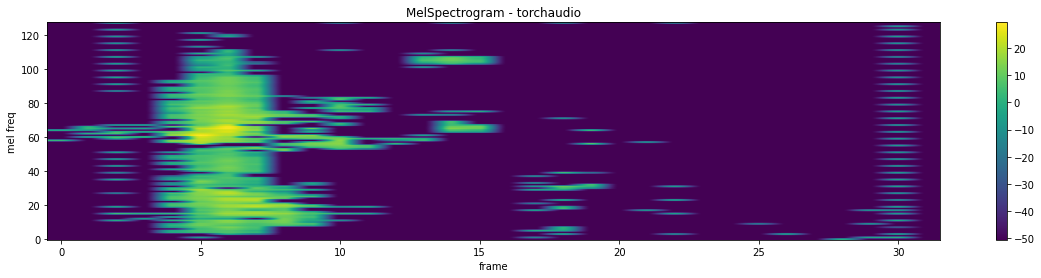

<Figure size 720x2160 with 0 Axes>

epoch: 51   step: 44   recon_loss: 162.94651794433594   perplexity:  82.58561706542969 
		commit_loss:  15.431571960449219   codebook loss:  61.726287841796875   total_loss:  240.1043701171875
=> Saving checkpoint
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


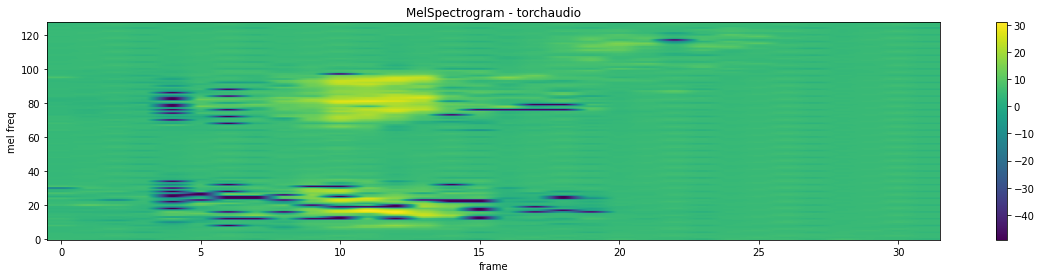

<Figure size 720x2160 with 0 Axes>

epoch: 101   step: 44   recon_loss: 139.38050842285156   perplexity:  165.0565185546875 
		commit_loss:  16.711471557617188   codebook loss:  66.84588623046875   total_loss:  222.9378662109375
=> Saving checkpoint
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


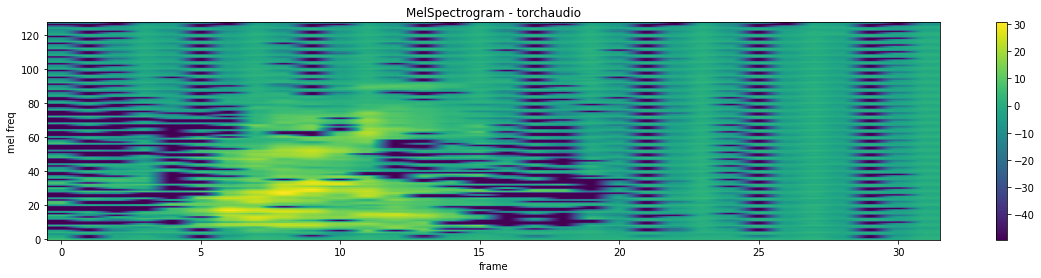

<Figure size 720x2160 with 0 Axes>

epoch: 151   step: 44   recon_loss: 161.2997589111328   perplexity:  136.2059326171875 
		commit_loss:  16.017026901245117   codebook loss:  64.06810760498047   total_loss:  241.3848876953125
=> Saving checkpoint
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


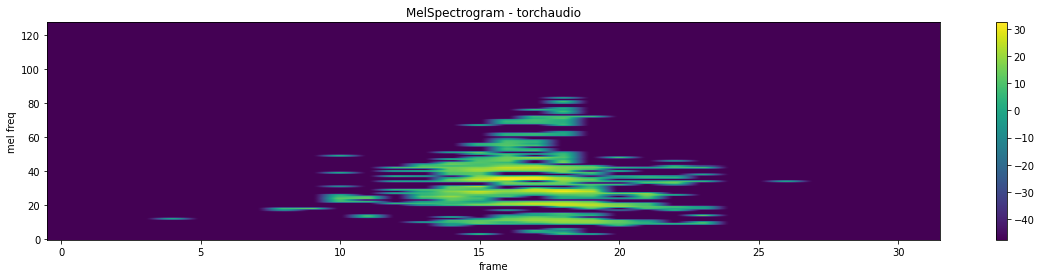

<Figure size 720x2160 with 0 Axes>

epoch: 201   step: 44   recon_loss: 209.53358459472656   perplexity:  95.25337982177734 
		commit_loss:  17.097570419311523   codebook loss:  68.3902816772461   total_loss:  295.02142333984375
=> Saving checkpoint
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


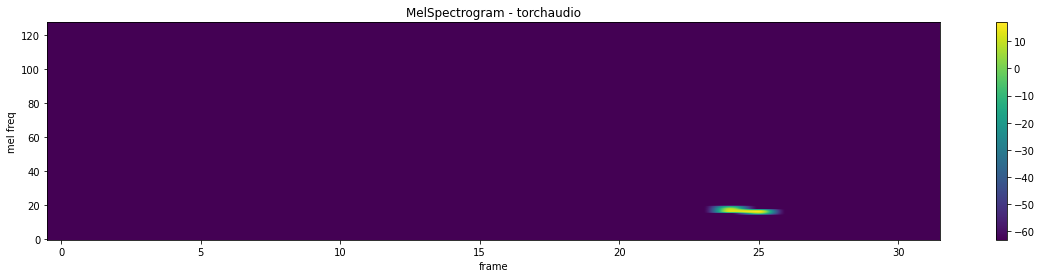

<Figure size 720x2160 with 0 Axes>

epoch: 251   step: 44   recon_loss: 588.16552734375   perplexity:  148.7283477783203 
		commit_loss:  16.108945846557617   codebook loss:  64.43578338623047   total_loss:  668.7102661132812
=> Saving checkpoint
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


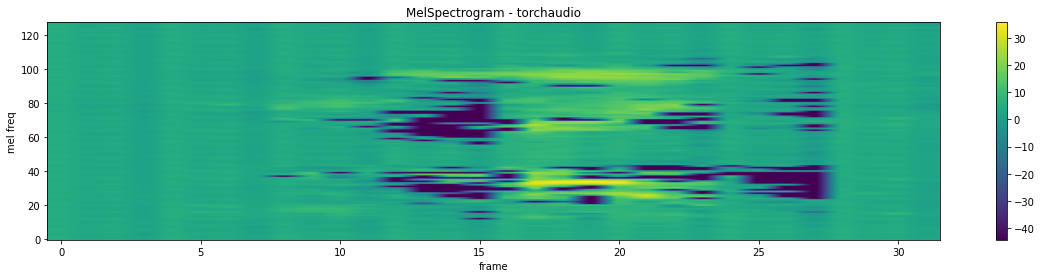

<Figure size 720x2160 with 0 Axes>

epoch: 301   step: 44   recon_loss: 160.40728759765625   perplexity:  128.96363830566406 
		commit_loss:  17.787477493286133   codebook loss:  71.14990997314453   total_loss:  249.34466552734375
=> Saving checkpoint
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


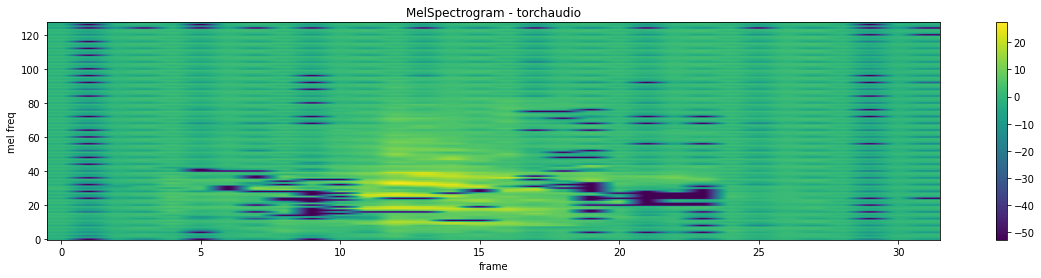

<Figure size 720x2160 with 0 Axes>

epoch: 351   step: 44   recon_loss: 167.2063446044922   perplexity:  165.7317657470703 
		commit_loss:  17.53678321838379   codebook loss:  70.14713287353516   total_loss:  254.8902587890625
=> Saving checkpoint
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


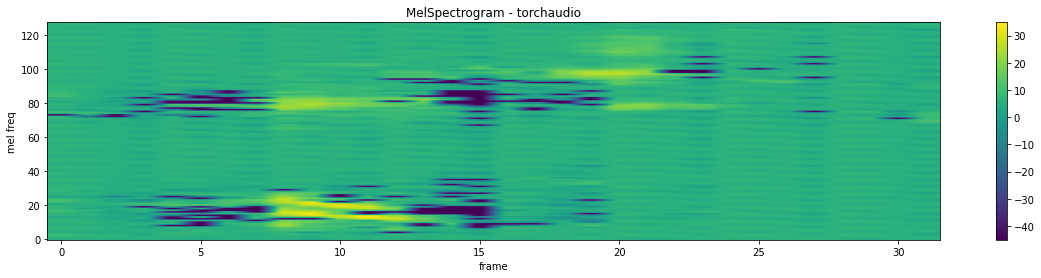

<Figure size 720x2160 with 0 Axes>

epoch: 401   step: 44   recon_loss: 139.44984436035156   perplexity:  144.97821044921875 
		commit_loss:  19.06171226501465   codebook loss:  76.2468490600586   total_loss:  234.75839233398438
=> Saving checkpoint
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


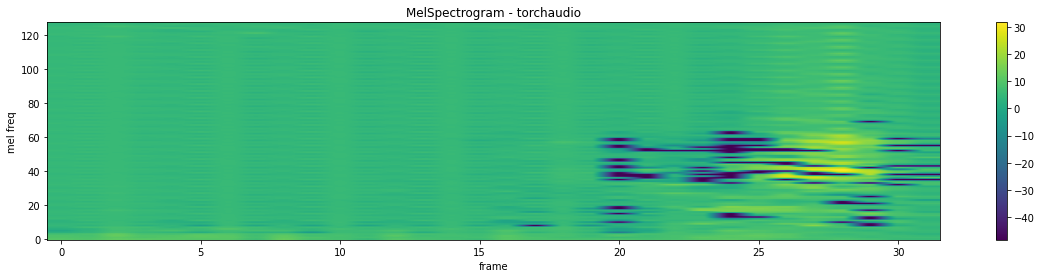

<Figure size 720x2160 with 0 Axes>

epoch: 451   step: 44   recon_loss: 155.86688232421875   perplexity:  141.44850158691406 
		commit_loss:  19.617313385009766   codebook loss:  78.46925354003906   total_loss:  253.9534454345703
=> Saving checkpoint
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500


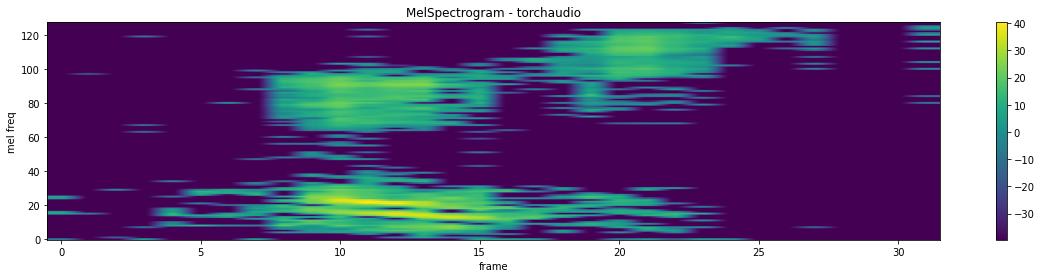

<Figure size 720x2160 with 0 Axes>

epoch: 501   step: 44   recon_loss: 189.4652099609375   perplexity:  128.31539916992188 
		commit_loss:  18.639301300048828   codebook loss:  74.55720520019531   total_loss:  282.6617126464844
=> Saving checkpoint
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550


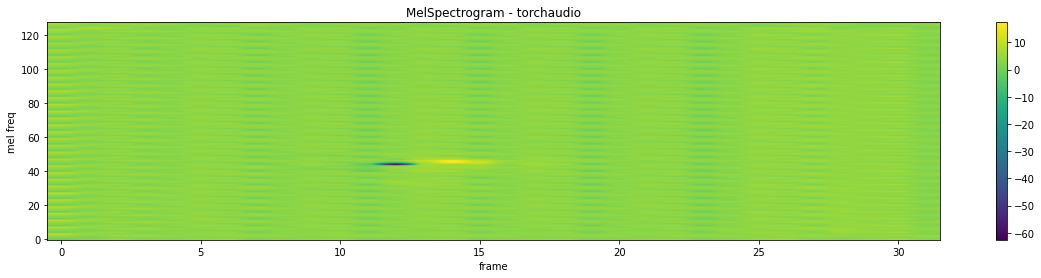

<Figure size 720x2160 with 0 Axes>

epoch: 551   step: 44   recon_loss: 125.94227600097656   perplexity:  156.6395721435547 
		commit_loss:  18.861474990844727   codebook loss:  75.4458999633789   total_loss:  220.24966430664062
=> Saving checkpoint
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600


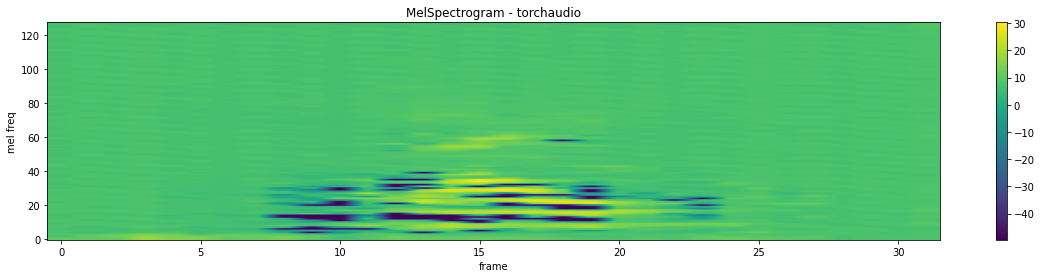

<Figure size 720x2160 with 0 Axes>

epoch: 601   step: 44   recon_loss: 174.2373504638672   perplexity:  135.0269317626953 
		commit_loss:  20.536685943603516   codebook loss:  82.14674377441406   total_loss:  276.9207763671875
=> Saving checkpoint
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650


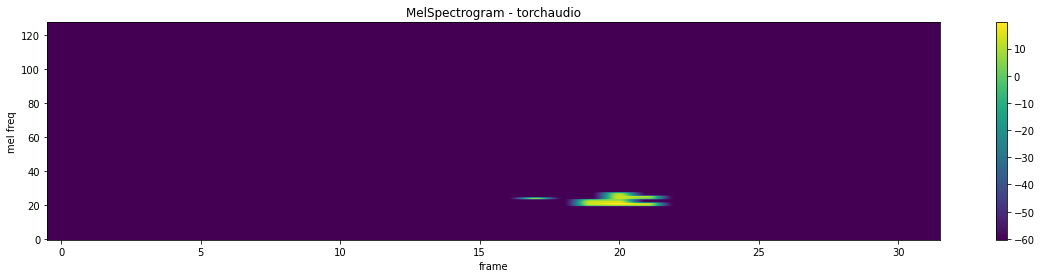

<Figure size 720x2160 with 0 Axes>

epoch: 651   step: 44   recon_loss: 661.861328125   perplexity:  126.17469787597656 
		commit_loss:  19.185792922973633   codebook loss:  76.74317169189453   total_loss:  757.790283203125
=> Saving checkpoint
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700


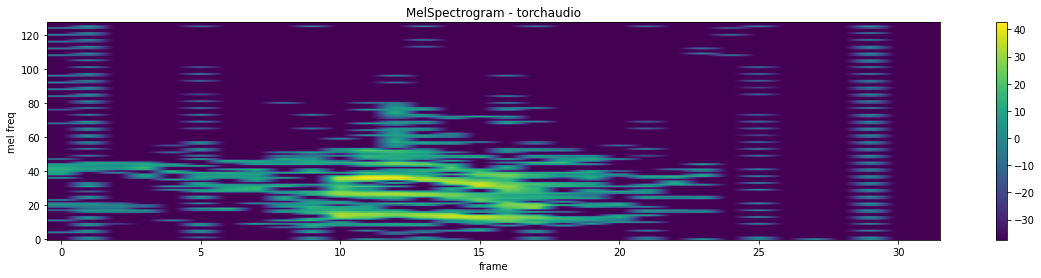

<Figure size 720x2160 with 0 Axes>

epoch: 701   step: 44   recon_loss: 191.3750457763672   perplexity:  113.72560119628906 
		commit_loss:  20.214885711669922   codebook loss:  80.85954284667969   total_loss:  292.449462890625
=> Saving checkpoint
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750


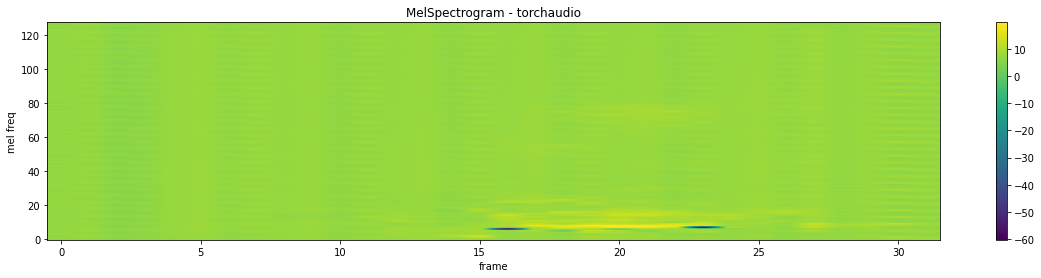

<Figure size 720x2160 with 0 Axes>

epoch: 751   step: 44   recon_loss: 119.94549560546875   perplexity:  108.44344329833984 
		commit_loss:  20.276561737060547   codebook loss:  81.10624694824219   total_loss:  221.32830810546875
=> Saving checkpoint
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800


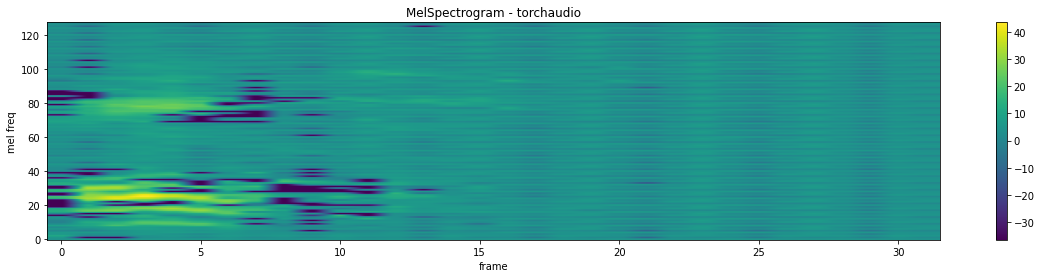

<Figure size 720x2160 with 0 Axes>

epoch: 801   step: 44   recon_loss: 168.45046997070312   perplexity:  140.53439331054688 
		commit_loss:  19.355167388916016   codebook loss:  77.42066955566406   total_loss:  265.226318359375
=> Saving checkpoint
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850


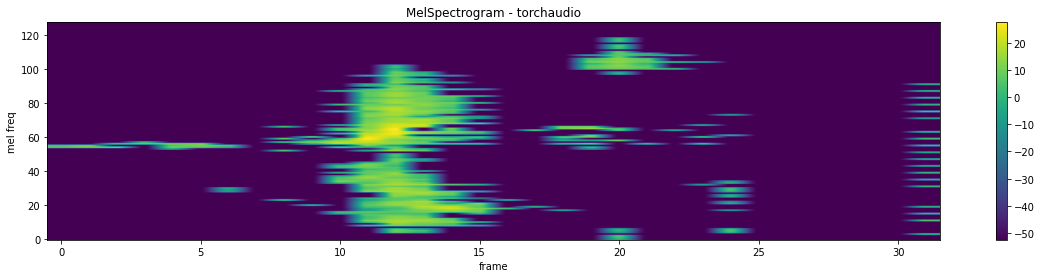

<Figure size 720x2160 with 0 Axes>

epoch: 851   step: 44   recon_loss: 171.1852264404297   perplexity:  121.23345947265625 
		commit_loss:  22.01055908203125   codebook loss:  88.042236328125   total_loss:  281.238037109375
=> Saving checkpoint
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900


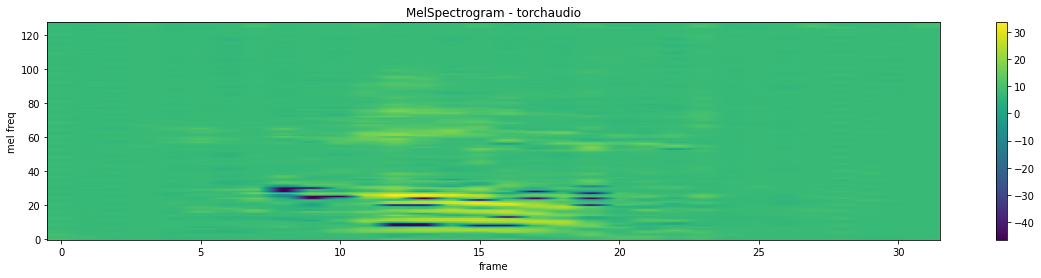

<Figure size 720x2160 with 0 Axes>

epoch: 901   step: 44   recon_loss: 406.96795654296875   perplexity:  110.26058959960938 
		commit_loss:  21.94431495666504   codebook loss:  87.77725982666016   total_loss:  516.6895141601562
=> Saving checkpoint
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950


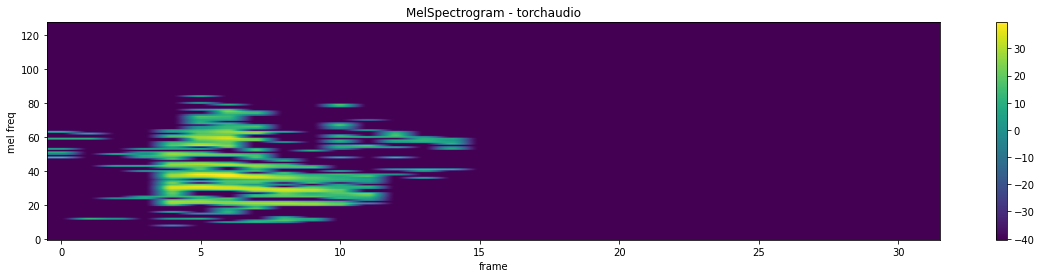

<Figure size 720x2160 with 0 Axes>

epoch: 951   step: 44   recon_loss: 1077.1090087890625   perplexity:  207.33876037597656 
		commit_loss:  23.287607192993164   codebook loss:  93.15042877197266   total_loss:  1193.5469970703125
=> Saving checkpoint
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000


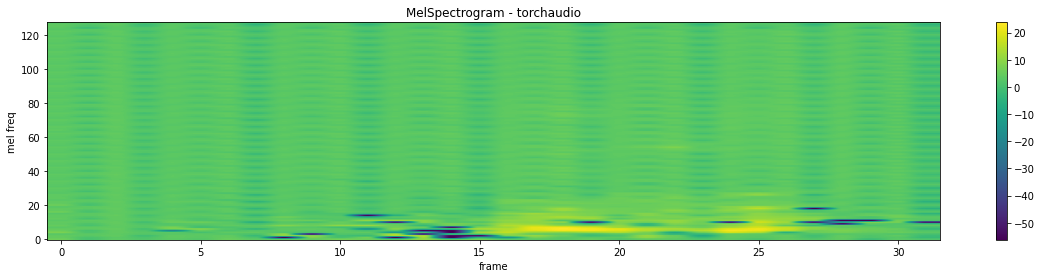

<Figure size 720x2160 with 0 Axes>

epoch: 1001   step: 44   recon_loss: 125.7173080444336   perplexity:  139.42298889160156 
		commit_loss:  23.02606773376465   codebook loss:  92.1042709350586   total_loss:  240.84765625
=> Saving checkpoint
1001
1002
1003
1004
Finish!!


In [ ]:
print("Start training VQ-VAE...")
load_checkpoint(torch.load("/content/drive/MyDrive/my_checkpoint.pth.tar"), model, optimizer)
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        # print(x.shape)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        # print(x_hat.shape)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
    print(epoch)    
        
    if epoch % 50 ==0:
            plot_spectrogram(
             x_hat[0][0].cpu().detach().numpy(), title="MelSpectrogram - torchaudio", ylabel='mel freq')   
            print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
              "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())



            res = librosa.feature.inverse.mel_to_audio(x_hat[6][0].cpu().detach().numpy(), 
                                           sr=16000, 
                                           n_fft=1024, 
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2.0, 
                                           n_iter=32)

            # step4 - save it as a wav file
            import soundfile as sf
            sf.write("test1.wav", res, 16000)

            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    # Try save checkpoint
            save_checkpoint(checkpoint)

    
print("Finish!!")

In [ ]:
x_hat[0].cpu().shape

torch.Size([1, 128, 32])

In [ ]:
res = librosa.feature.inverse.mel_to_audio(x_hat[23][0].cpu().detach().numpy(), 
                                           sr=22050, 
                                           n_fft=2048, 
                                           hop_length=512, 
                                           win_length=None, 
                                           window='hann', 
                                           center=True, 
                                           pad_mode='reflect', 
                                           power=2.0, 
                                           n_iter=32)

# step4 - save it as a wav file
import soundfile as sf
sf.write("test1.wav", res, 22050)

In [ ]:
ipd.Audio("/content/test1.wav")

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt')